## model_eicu_compact


## Prepare


In [1]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from common_eicu import KEY_IDENTITY, KEY_OFFSET, \
    KEY_FLAG, CATEGORICAL_COLUMNS
from common_model_eicu import SEED, SCORING, cv, \
    get_full_data, test_model
from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs


In [2]:
METRIC_PERIOD = 50

COMPACT_COLUMNS = [
    KEY_OFFSET,
    'albumin',
    'lymph',
    'heart rate',
    'respiration rate',
    'total protein',
    'Hct',
    'creatinine',
    'pH',
    'calcium',
    'WBC',
    'BMI',
    'AST',
    'platelet',
    'MAP',
]

CATEGORICAL_COLUMNS_COMPACT = list(
    filter(
        lambda col: col in COMPACT_COLUMNS,
        CATEGORICAL_COLUMNS,
    )
)

CATEGORICAL_COLUMNS_COMPACT


[]

In [3]:
shap.initjs()


In [4]:
plt.rcParams['figure.facecolor'] = '#FFF'


In [5]:
df_data = get_full_data()

X_raw = df_data[COMPACT_COLUMNS]
y = df_data[KEY_FLAG].ravel()
groups = df_data[KEY_IDENTITY].ravel()


## Optimize


In [6]:
catboost_model_opt = CatBoostClassifier(
    cat_features=CATEGORICAL_COLUMNS_COMPACT,
    task_type='GPU',
    devices='0',
    metric_period=METRIC_PERIOD,
    random_state=SEED,
    logging_level='Silent',
    boosting_type='Plain',
)


In [7]:
def opt_target_function(**params):

    catboost_model_opt.set_params(
        iterations=int(params['iterations']),
        depth=int(params['depth']),
        learning_rate=params['learning_rate'],
        # bagging_temperature=params['bagging_temperature'],
        l2_leaf_reg=params['l2_leaf_reg'],
    )

    scores = cross_val_score(
        catboost_model_opt,
        X_raw,
        y,
        groups=groups,
        cv=cv,
        scoring='roc_auc',
    )

    return scores.mean()


In [8]:
# baseline score
opt_target_function(
    iterations=1000,
    depth=6,
    learning_rate=0.03,
    # bagging_temperature=1.0,
    l2_leaf_reg=3.0,
)


0.9021899997654852

In [9]:
optimizer = BayesianOptimization(
    f=opt_target_function,
    # The bounds are inclusive here.
    pbounds={
        'iterations': (100, 1000),
        'depth': (6, 10),
        'learning_rate': (0.01, 0.30),
        # 'bagging_temperature': (1, 100),
        'l2_leaf_reg': (1, 200),
    },
    verbose=2,  # 0: silent; 1: log max; 2: log all
    random_state=SEED,
    # bounds_transformer=SequentialDomainReductionTransformer(
    #     minimum_window=0.1,
    # ),
)


In [10]:
PATH_OPT_LOG = './data/optimization_log.json'


In [14]:
# load progress
load_logs(optimizer, logs=[PATH_OPT_LOG])


In [11]:
# setup logger
# (This will remove the existing file!!!)
opt_logger = JSONLogger(path=PATH_OPT_LOG)
optimizer.subscribe(Events.OPTIMIZATION_STEP, opt_logger)


In [12]:
# guiding
optimizer.probe(
    params={
        'iterations': 400,
        'depth': 6,
        'learning_rate': 0.03,
        # 'bagging_temperature': 1.5,
        'l2_leaf_reg': 18.0,
    },
    lazy=True,
)


In [17]:
%%time
optimizer.maximize(
    init_points=3,
    n_iter=2,
)


CPU times: total: 8min 38s
Wall time: 5min 16s


In [18]:
optimizer.max


{'target': 0.9068151561836872,
 'params': {'depth': 6.586832826989683,
  'iterations': 350.73086761468903,
  'l2_leaf_reg': 17.684483387754195,
  'learning_rate': 0.028174953216289815}}

## Evaluate


In [7]:
catboost_model_compact = CatBoostClassifier(
    cat_features=CATEGORICAL_COLUMNS_COMPACT,
    task_type='GPU',
    devices='0',
    metric_period=METRIC_PERIOD,
    random_state=SEED,
    logging_level='Silent',
    boosting_type='Plain',
    # bagging_temperature=1.0,
    depth=6,
    iterations=350,
    l2_leaf_reg=17.6845,
    learning_rate=0.0282,
)


In [21]:
%%time
# test optimized compact model
test_model(
    catboost_model_compact,
    X_raw,
    y,
    groups,
)


>>> CV Result
accuracy_mean: 0.9612
accuracy_std:  0.0066
auc_mean:      0.9069
auc_std:       0.0142
CPU times: total: 1min 2s
Wall time: 40 s


## Fit


In [8]:
catboost_model_compact.fit(X_raw, y)


## Export


In [9]:
catboost_model_compact.save_model(
    './sepsis-pics-tool/backend/model.cbm',
    format='cbm',
)


## SHAP


In [23]:
explainer = shap.Explainer(catboost_model_compact)
shap_values = explainer(X_raw)


In [24]:
df_data[[KEY_IDENTITY, KEY_FLAG]] \
    .groupby(KEY_FLAG) \
    .head(1)


,patientunitstayid,flag
0,141288,0
205,148182,1


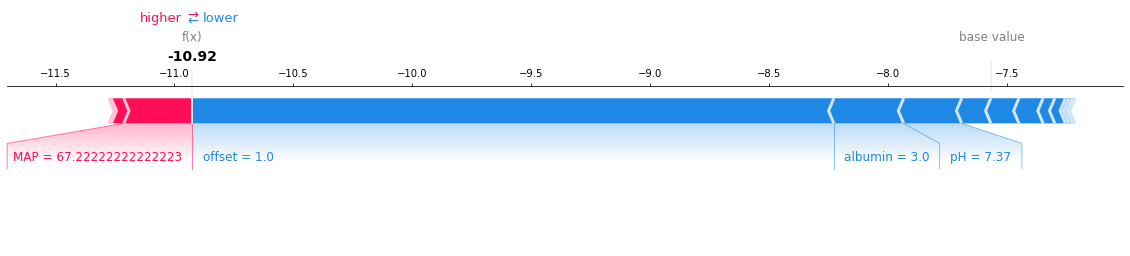

In [33]:
shap.plots.force(
    shap_values[0],
    matplotlib=True,
    # link='logit',
)


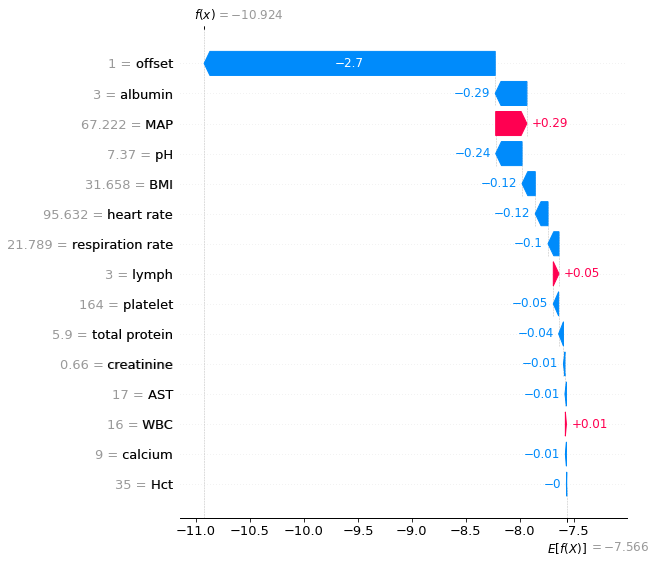

In [30]:
shap.plots.waterfall(
    shap_values[0],
    max_display=99,
)


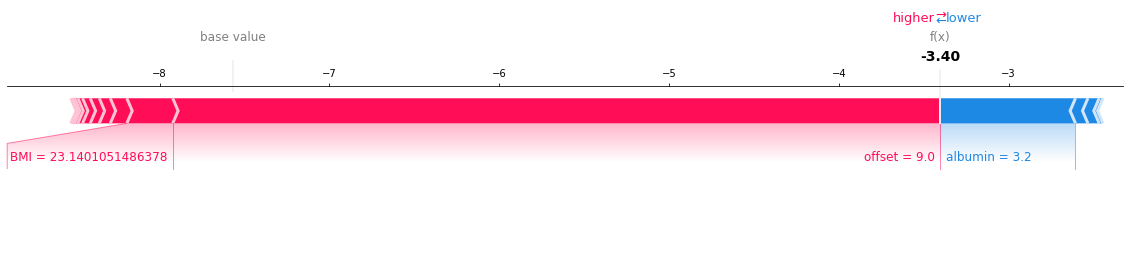

In [39]:
shap.plots.force(
    shap_values[205],
    matplotlib=True,
    contribution_threshold=0.15,
    # link='logit',
)


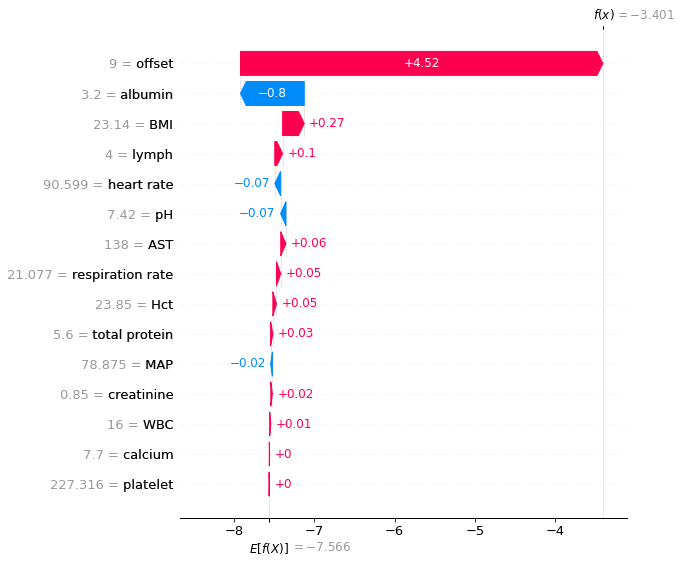

In [31]:
shap.plots.waterfall(
    shap_values[205],
    max_display=99,
)
